**PROBLEM 2 - SECTION 2**

Import Libraries

In [ ]:
!pip install nltk

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import re

Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
!gdown 1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB

Downloading...
From (original): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
From (redirected): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&confirm=t&uuid=72ff7ab2-6d06-45e0-830e-e57ee0ba0f31
To: /content/train_data.csv
100% 635M/635M [00:07<00:00, 83.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB
To: /content/test_data.csv
100% 15.6M/15.6M [00:00<00:00, 22.8MB/s]


In [ ]:
train_data = pd.read_csv("/content/train_data.csv")
titles = pd.read_csv('/content/drive/MyDrive/title_brand.csv')

<ipython-input-8-f105922c3838>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("/content/train_data.csv")


Identify Reviews mentioning Guarantee

In [ ]:
words = ['warranty', 'guarantee', 'guaranty', 'Assurance', 'Insurance', 'Surety', 'Pledge', 'Commitment', 'Covenant', 'Promise', 'Bond',
            'Certification', 'Validation', 'Indemnity', 'Protection', 'Coverage', 'Credibility', 'Backing', 'Support', 'Trust', 'Affirmation', "warranty",
            "warranties", "waranty",  "warrantee", "warrantees", "warrenty", "guarantee", "guarantees", "guaranty", "guaranties", "garantee", "guarrantee", "guarentee", "garrantee"  ]

In [ ]:
def filtered_review(reviewText):
    for word in words:
        if re.search(rf'\b{re.escape(word)}\b', reviewText):
            return True
    return False

In [ ]:
new_df = train_data[train_data['reviewText'].apply(filtered_review)]
new_df = new_df[["asin", "reviewText", "overall"]]

In [ ]:
merged_df = pd.merge(new_df, titles, on='asin')
merged_df

,asin,reviewText,overall,title,brand
0,B000001OM4,This adapter works well with my 1994 Corvette....,4,Maxell CD-330 CD-to-Cassette Audio Adapter (19...,Maxell
1,B00000J4EY,I mounted this and plugged it all up last nigh...,3,"Kensington SmartSockets 6-Outlet, 16-Foot Cord...",Kensington
2,B00000J4EY,I mounted this and plugged it all up last nigh...,3,"Kensington SmartSockets 6-Outlet, 16-Foot Cord...",Kensington
3,B00000K2YR,Out of the box would not transmit. Connect to...,1,Midland 75-822 40 Channel CB-Way Radio,Midland
4,B00000K2YR,Out of the box would not transmit. Connect to...,1,Midland 75-822 40 Channel CB-Way Radio,Midland
...,...,...,...,...,...
21210,B01HEOC8B8,The unit was a better built than the original ...,5,TFDirect Lift Chair Power Recliner AC/DC Switc...,TFDirect
21211,B01HEXFQVI,"I use a variety of microcontrollers (RPi, Ardu...",5,HomeSpot 5ft - 1.5m Long USB 2.0 to Micro USB ...,HomeSpot
21212,B01HH5G93C,I ordered and quickly received the iPad Pro 9....,5,iPad Pro 9.7 2016 case by KIQ Heavy Duty Hybri...,KIQ
21213,B01HHRGSEA,This is my fourth of these tablets. The first...,1,9.7 inch Tablet Octa Core 2560X1600 IPS Blueto...,FX


In [ ]:
grouped_df = pd.DataFrame(
    merged_df.groupby('title').agg(
        mean_rate=('overall', np.mean))
).reset_index()

In [ ]:
grouped_df = grouped_df.sort_values(["mean_rate"], ascending=False).reset_index(drop=True)
grouped_df

,title,mean_rate
0,RoadPro Replacement Speaker Wire 10 ft With 3...,5.0
1,zigels Laptop Backpack Padded Stylish for Trav...,5.0
2,xmartO Expandable Wireless Security Camera Sys...,5.0
3,xmartO 1080p HD Wireless Security Camera Syste...,5.0
4,Accell DisplayPort to DVI-D Dual-Link Adapter...,5.0
...,...,...
10937,Sandisk Z400s 128GB Solid State Drive (2.5&rdq...,1.0
10938,Sangean H201 Portable AM/FM/Weather Alert Digi...,1.0
10939,Neewer TT860LI-ION BATTERY Speedlite Flash E T...,1.0
10940,Amcrest AMDV960H8-4B4D 960H 8CH Video Security...,1.0


Sentiment Polarity

In [ ]:
def classify_sentiment(row):
    if row["mean_rate"] > 3.5:
        return 'positive'
    elif row["mean_rate"] < 2.5:
        return 'negative'
    else:
        return 'neutral'

grouped_df['sentiment'] = grouped_df.apply(classify_sentiment, axis=1)
print(grouped_df)

                                                   title  mean_rate sentiment
0       RoadPro Replacement Speaker Wire 10 ft With 3...        5.0  positive
1      zigels Laptop Backpack Padded Stylish for Trav...        5.0  positive
2      xmartO Expandable Wireless Security Camera Sys...        5.0  positive
3      xmartO 1080p HD Wireless Security Camera Syste...        5.0  positive
4       Accell DisplayPort to DVI-D Dual-Link Adapter...        5.0  positive
...                                                  ...        ...       ...
10937  Sandisk Z400s 128GB Solid State Drive (2.5&rdq...        1.0  negative
10938  Sangean H201 Portable AM/FM/Weather Alert Digi...        1.0  negative
10939  Neewer TT860LI-ION BATTERY Speedlite Flash E T...        1.0  negative
10940  Amcrest AMDV960H8-4B4D 960H 8CH Video Security...        1.0  negative
10941  Sangean WFR-28 Internet Radio / FM-RBDS / USB ...        1.0  negative

[10942 rows x 3 columns]


In [ ]:
sentiment_summary = grouped_df['sentiment'].value_counts()
print(sentiment_summary)

sentiment
positive    5349
negative    3656
neutral     1937
Name: count, dtype: int64


<ipython-input-21-edec7134dda0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_summary.index, y=sentiment_summary.values, palette='viridis')


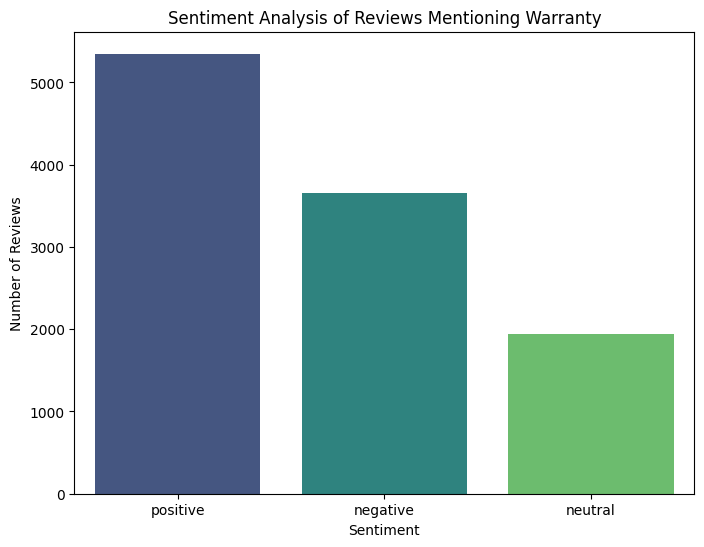

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_summary.index, y=sentiment_summary.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Analysis of Reviews Mentioning Warranty')
plt.show()


In [ ]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
grouped_df['sentiment_score'] = grouped_df['sentiment'].map(sentiment_mapping)
correlation = grouped_df[['sentiment_score', 'mean_rate']].corr().iloc[0, 1]
print(f'Correlation between sentiment score and rating: {correlation:.2f}')

Correlation between sentiment score and rating: 0.96
